# **Predicting the perception of deprivation from VHR Satelite Images.**

# Intro

This code is developed by [**Taïs Grippa**](https://github.com/tgrippa) for the **PARTIMAP** project, based on the initial code of [**Eqi Luo**](https://github.com/EqiLuo/MappingDeprivation). 



# 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import sqlite3
import cv2
import shutil
import time
import tempfile

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import RandomCrop, RandomContrast
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K

Check the version of Tensorflow. It should be 2.7.0

In [4]:
print(tf.__version__)

2.8.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [5]:
! nvidia-smi

Mon Feb 14 16:54:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0  On |                  N/A |
| 24%   37C    P8    22W / 215W |    638MiB /  7981MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Configure Tensorflow (v2.8) for deterministic behavior (to get reproducible results). See official manual [HERE](https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism). NOTICE: Has never worked properly :/

In [6]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

Import Keras Tuner for Hyperparameter tuning

In [7]:
import keras_tuner as kt
from keras_tuner import HyperModel

Setup Keras to work with Mixed Precision to speed up the learning process and reduce GPU memory required. More information [HERE](https://keras.io/api/mixed_precision/).

In [8]:
# Setup Keras Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


Import custom functions

In [9]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

In [10]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir

# 1. Data preparation 

**In this part, we load, organize and transform all the input data to the format of input for deep learning model.**

## 1.1 Loading, structuring the data

In [11]:
# Define working path 
root = "/home/partimap/PARTIMAP_processing"
#image_path = os.path.join(root, "partimap_wv3_rgb")
image_path = os.path.join(root, "partimap_wv3_VNIR")
label_path = os.path.join(root, "partimap_ranking")
output_path = os.path.join(root, "output")
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [12]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, results_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/partimap/PARTIMAP_processing/output' already exists
The folder '/home/partimap/PARTIMAP_processing/output/model' already exists
The folder '/home/partimap/PARTIMAP_processing/output/results' already exists


In [13]:
# Create a list of all the filenames of images
tile_list = [x for x in os.listdir(image_path) if x.endswith(".tif")]
# Sort the list naturally based on the number in the filename.
tile_list = natsorted(tile_list)

In [14]:
# Remove unwanted images (images whith clouds that have been removed from the True-Skill ranking)
unwanted_ids = [370,371,378,386,387,389,396,397,408,417,418,421,422,430,431,444,445,446,447,456,459,460,461,462,466,467,468,469,470,473,474,475,476,479,483,484,488,493,502,503,504,510,520]
tile_list = [x for x in tile_list if int(os.path.splitext(x)[0].split("_")[-1]) not in unwanted_ids]

In [15]:
# Loop over and read all the images as numpy array, then stack them together 
rawimgsize = 333 #raw data size (333x333 pixel)
resizesize = 128 #resampling size
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=rawimgsize, win_ysize=rawimgsize, buf_xsize=resizesize, buf_ysize=resizesize) #resize (resample) raw data 
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    stack.append(data.astype(np.float16))

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(2005, 128, 128, 4)


In [16]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

float16


In [17]:
stack[0,:,:,0]

array([[187., 201., 198., ..., 283., 280., 233.],
       [164., 165., 160., ..., 332., 159., 103.],
       [157., 152., 157., ...,  94.,  93., 104.],
       ...,
       [295., 295., 299., ..., 122.,  70.,  56.],
       [117., 114., 139., ..., 115.,  73.,  65.],
       [ 14.,  20.,  21., ..., 140.,  90.,  81.]], dtype=float16)

In [18]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

def standardise_channel(image_data):
    for ch_idx in range(image_data.shape[-1])[:1]:
        mean = image_data[:,:,:,ch_idx].mean()
        std = image_data[:,:,:,ch_idx].std()
        image_data[:,:,:,ch_idx] -= mean
        image_data[:,:,:,ch_idx] /= std
    return image_data
    
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0, dtype=np.float32)
    image_data /= (np.max(stack, axis=0, dtype=np.float32) - np.min(stack, axis=0, dtype=np.float32))
    return image_data

#stack = standardise_channel(stack)
stack = standardise(stack)
#stack = normalise_01(stack)
print(stack.shape)
print(stack.dtype)

(2005, 128, 128, 4)
float16


In [19]:
stack[0,:,:,0]

array([[ 0.2058  ,  0.3345  ,  0.3196  , ...,  1.101   ,  1.159   ,
         0.701   ],
       [-0.01393 , -0.002438, -0.04227 , ...,  1.588   , -0.0693  ,
        -0.641   ],
       [-0.0964  , -0.1333  , -0.0985  , ..., -0.698   , -0.7334  ,
        -0.635   ],
       ...,
       [ 1.267   ,  1.169   ,  1.25    , ..., -0.4238  , -0.976   ,
        -1.1     ],
       [-0.4797  , -0.531   , -0.2932  , ..., -0.4907  , -0.9155  ,
        -0.946   ],
       [-1.446   , -1.427   , -1.449   , ..., -0.258   , -0.716   ,
        -0.808   ]], dtype=float16)

In [20]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


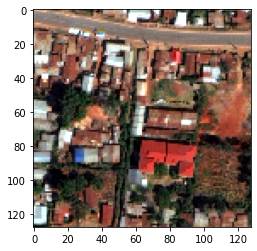

In [21]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

**Load the labels from SQLite and store it in numpy serie** 

In [22]:
# Load the labels stored in CSV into a pandas DataFrame
df_labels = pd.read_csv(os.path.join(label_path,"ranking_p3_20220202_NoClouds.csv"))
df_labels.head()

,photo_id,value
0,1.0,27.246599
1,2.0,25.581902
2,3.0,26.108904
3,4.0,26.940680
4,5.0,25.817791


In [23]:
# Extract the values of perception score and covert it to a 1-d array 
scores = df_labels.loc[:,'value'].values.astype(np.float16)
photo_id = df_labels.loc[:,'photo_id'].values

In [24]:
# Now we need to reshape the 1-d array to a 2-d array 
scores = scores.reshape(scores.size,-1)
photo_id = photo_id.reshape(photo_id.size,-1)

# Check the shape and datatype of reference data
print(scores.shape)
print(scores.dtype)
print(scores)

(2005, 1)
float16
[[27.25]
 [25.58]
 [26.11]
 ...
 [25.14]
 [27.27]
 [26.22]]


In [25]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(scores.shape)

(2005, 128, 128, 4)
(2005, 1)


In [26]:
# Check if labels and images ID match
set_images = set([int(os.path.splitext(x)[0].split("_")[-1]) for x in tile_list])
set_label = set(df_labels.loc[:,'photo_id'].values.tolist())
missing_label = list(sorted(set_images - set_label))
missing_image = list(sorted(set_label - set_images))
if missing_label or missing_image: 
    print('Label(s) ID missing:', missing_label)
    print('Image(s) ID missing:', missing_image)
else: 
    print('Labels and images ID match perfectly') 

Labels and images ID match perfectly


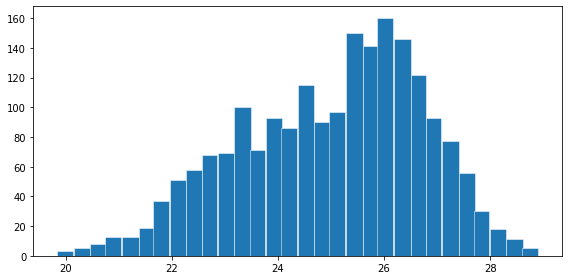

In [27]:
# print the distribution of target variables (y)
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(scores, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

## 1.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

the proportion of training+validation and test follows the rule of thumb, 70% vs 30%.

In [28]:
# Split the inputs. Note that variable 'stack' is the X (imagery), and variable 'score' is the Y (labels).  
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
    stack, scores, photo_id, test_size = 0.1, random_state = SEED) # specify the random state to ensure replicable output across multiple function calls.

# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1804, 128, 128, 4)
(1804, 1)
(201, 128, 128, 4)
(201, 1)


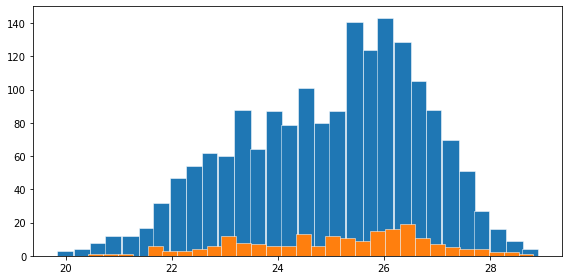

In [29]:
# print the distribution of target variables (y) in training and validation sets
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(y_train, bins = 30, edgecolor='white', linewidth=0.5)
axs.hist(y_test, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

# 2. Definition of several functions for the model

## 2.1 Eval metric and Data augmentation layers

#### **Coefficient of determination**

In [30]:
# Specify the R2 calculation formula to use as an assessment metric. 
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#### **Data augmentation definition**

In [31]:
# Define data augmentation to be included at the top of the sequential model 
data_augmentation = tf.keras.Sequential([
                        layers.RandomFlip("vertical"),
                        layers.RandomRotation(0.2, fill_mode='reflect'),
                        layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode='reflect'),
                    ])

# 3 Model training
In this part, we build a VGG-like model to predict the deprivation degree. We fine-tune the model's hyperparameter in different stages. 

## 3.1 Hyperparameters tuning
In this part, we build a VGG-like model to predict the deprivation degree. We fine-tune the model's hyperparameter in different stages. 

### 3.1.1 HP: Conv filters + FC nodes

After running multiple times this HP tuning set, the best result is not always the same. But at least there is a progression in the number of filter for the convolutions layers. The number of nodes in the FC layers is consistent and equal to 256/256.

In [32]:
# Input shape 
#input_shape = (256, 256, 3)
input_shape = (128, 128, 4)
#input_shape = (64, 64, 3)

In [33]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = hp.Choice("hp_filters_blk1", [32,64]) #Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = hp.Choice("hp_filters_blk2", [32,64,128]) #Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = hp.Choice("hp_filters_blk3", [128,256]) #Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool

    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = hp.Choice("hp_filters_FC1", [128,256]) #Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = hp.Choice("hp_filters_FC2", [128,256]) #Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))
    
    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    opt = Adam(learning_rate=1e-3)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [ ]:
# Check if the Hyperparameter model works fine
VGG_model(kt.HyperParameters())

In [ ]:
# Keras Tuner with Hyperband
tuner = kt.Hyperband(
    hypermodel=VGG_model,
    #objective=kt.Objective("val_loss", direction="min"),
    objective=kt.Objective("val_coeff_determination", direction="max"),
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    seed=SEED,
    overwrite=True,
    directory=os.path.join(model_path,"Tuner"),
    project_name="Partimap_HpTuning_A",
)

In [ ]:
# Search space summary
tuner.search_space_summary()

In [ ]:
## Define CALLBACKS
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss",mode="min",patience=20) # probably needs to be more patient, but kaggle time is limited

## HP SEARCH
# Save current time for time management
starttime = start_processing()
# Define batch size and number of epoch to train
BSIZE = 64
NB_EPOCHS = 30
# Perform the HP search
tuner.search(x_train, y_train, 
             batch_size=BSIZE, 
             epochs=NB_EPOCHS, 
             validation_data=(x_test,y_test),
             callbacks=[early])
## Print processing time
print_processing_time(starttime ,"Process achieved in ")

In [ ]:
# Summary of the HP tuning
tuner.results_summary(num_trials=7)

In [34]:
# Print best hyperparameters for tuning A
best_hp_A = {'hp_filters_blk1': 32,
 'hp_filters_blk2': 64,
 'hp_filters_blk3': 256,
 'hp_filters_FC1': 128,
 'hp_filters_FC2': 256,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '33329bc3ab0971756d77bb78ec740f4f'}

### 3.1.2 HP: Network depth (Block 4)

The preivous stage of hyperparameter tuning showed no tendancy to overfitting. So, Dropout rate after FC1 ans FC2 has been maintained at its previous value 0.1 and will not be optimized. 

Here, we use the RandomSearch algorithm instead of the Hyperband algorithm since we don't test much values.     

In [ ]:
# Input shape 
#input_shape = (256, 256, 3)
input_shape = (128, 128, 4)
#input_shape = (64, 64, 3)

In [ ]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = best_hp_A['hp_filters_blk1'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = best_hp_A['hp_filters_blk2'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = best_hp_A['hp_filters_blk3'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool
    
    # block 4 
    hp_bool_blk4 = hp.Boolean('hp_bool_blk4', default=True) #Hyperparameter tuning
    if hp_bool_blk4:
        hp_filters_blk4 = hp.Choice("filters_blk4", [128,256,512], parent_name='hp_bool_blk4', parent_values=True) #Hyperparameter tuning
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv1')) #block4_conv1
        model.add(BatchNormalization(axis=-1, name='block4_bn1'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv2')) #block4_conv2
        model.add(BatchNormalization(axis=-1, name='block4_bn2'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv3')) #block4_conv3
        model.add(BatchNormalization(axis=-1, name='block4_bn3'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), name='block4_pool')) #block4_pool   
    
    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = best_hp_A['hp_filters_FC1'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = best_hp_A['hp_filters_FC2'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))

    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    opt = Adam(learning_rate=1e-3)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [ ]:
# Check if the Hyperparameter model works fine
VGG_model(kt.HyperParameters())

In [ ]:
# Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    hypermodel=VGG_model,
    #objective=kt.Objective("val_loss", direction="min"),
    objective=kt.Objective("val_coeff_determination", direction="max"),
    max_trials=10, #Maximum number of HP combination to test
    executions_per_trial=3, #Number of execution of the same HP combination
    overwrite=True,
    directory=os.path.join(model_path,"Tuner"),
    project_name="Partimap_HpTuning_B",
)

In [ ]:
# Search space summary
tuner.search_space_summary()

In [ ]:
## Define CALLBACKS
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss",mode="min",patience=20) # probably needs to be more patient, but kaggle time is limited

## HP SEARCH
# Save current time for time management
starttime = start_processing()
# Define batch size and number of epoch to train
BSIZE = 64
NB_EPOCHS = 50
# Perform the HP search
tuner.search(x_train, y_train, 
             batch_size=BSIZE, 
             epochs=NB_EPOCHS, 
             validation_data=(x_test,y_test),
             callbacks=[early])
## Print processing time
print_processing_time(starttime ,"Process achieved in ")

In [ ]:
# Summary of the HP tuning
tuner.results_summary(num_trials=3)

In [35]:
# Print best hyperparameters
best_hp_B = {'hp_bool_blk4': False}

### 3.1.3 HP: Learning rate for Adam 

In [76]:
# Input shape 
#input_shape = (256, 256, 3)
input_shape = (128, 128, 4)
#input_shape = (64, 64, 3)

In [77]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = best_hp_A['hp_filters_blk1'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = best_hp_A['hp_filters_blk2'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = best_hp_A['hp_filters_blk3'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool
    
    # block 4 
    hp_bool_blk4 = best_hp_B['hp_bool_blk4'] #Value found after previous Hyperparameter tuning
    if hp_bool_blk4:
        hp_filters_blk4 = best_hp_B['hp_filters_blk4'] #Value found after previous Hyperparameter tuning
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv1')) #block4_conv1
        model.add(BatchNormalization(axis=-1, name='block4_bn1'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv2')) #block4_conv2
        model.add(BatchNormalization(axis=-1, name='block4_bn2'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv3')) #block4_conv3
        model.add(BatchNormalization(axis=-1, name='block4_bn3'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), name='block4_pool')) #block4_pool   
    
    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = best_hp_A['hp_filters_FC1'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = best_hp_A['hp_filters_FC2'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))

    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    hp_lr = hp.Float("hp_lr", min_value=1e-4, max_value=1e-1, sampling="log")
    opt = Adam(learning_rate=hp_lr)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [78]:
# Check if the Hyperparameter model works fine
VGG_model(kt.HyperParameters())

In [79]:
# Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    hypermodel=VGG_model,
    #objective=kt.Objective("val_loss", direction="min"),
    objective=kt.Objective("val_coeff_determination", direction="max"),
    max_trials=7, #Maximum number of HP combination to test
    executions_per_trial=1, #Number of execution of the same HP combination
    overwrite=True,
    directory=os.path.join(model_path,"Tuner"),
    project_name="Partimap_HpTuning_C",
)

In [80]:
# Search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 1
hp_lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [81]:
## Define CALLBACKS
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss",mode="min",patience=20) # probably needs to be more patient, but kaggle time is limited

## HP SEARCH
# Save current time for time management
starttime = start_processing()
# Define batch size and number of epoch to train
BSIZE = 64
NB_EPOCHS = 100
# Perform the HP search
tuner.search(x_train, y_train, 
             batch_size=BSIZE, 
             epochs=NB_EPOCHS, 
             validation_data=(x_test,y_test),
             callbacks=[early])
## Print processing time
print_processing_time(starttime ,"Process achieved in ")

Trial 1 Complete [00h 05m 52s]
val_coeff_determination: 0.5635591745376587

Best val_coeff_determination So Far: 0.5635591745376587
Total elapsed time: 00h 05m 52s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
hp_lr             |0.00077689        |0.00026075        

Epoch 1/100
29/29 [==============================] - 8s 135ms/step - loss: 564.4534 - mean_absolute_error: 23.6675 - root_mean_squared_error: 23.7578 - coeff_determination: -200.3398 - val_loss: 606.5074 - val_mean_absolute_error: 24.5483 - val_root_mean_squared_error: 24.6236 - val_coeff_determination: -217.7855
Epoch 2/100
29/29 [==============================] - 4s 154ms/step - loss: 414.6569 - mean_absolute_error: 20.2168 - root_mean_squared_error: 20.3633 - coeff_determination: -142.0561 - val_loss: 556.3085 - val_mean_absolute_error: 23.4510 - val_root_mean_squared_error: 23.5853 - val_coeff_determination: -198.7330
Epoch 3/100
29/29 [==============================] - 4s 147ms/st

KeyboardInterrupt: 

In [ ]:
# Summary of the HP tuning
tuner.results_summary(num_trials=3)

In [ ]:
# Print best hyperparameters
best_hp_C = tuner.get_best_hyperparameters()[0]
best_hp_C.values

In [ ]:
# Get the best model with restored weights from the best checkpoint (at the end of the best epoch of best trial). 
best_model = tuner.get_best_models(1)[0]
# Print the best model summary
best_model.build(x_test.shape)
best_model.summary()

## 3.2 Retrain few more epochs from the last checkpoint with the best parameters 

In [57]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = best_hp_A['hp_filters_blk1'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = best_hp_A['hp_filters_blk2'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = best_hp_A['hp_filters_blk3'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool
    
    # block 4 
    hp_bool_blk4 = best_hp_B['hp_bool_blk4'] #Value found after previous Hyperparameter tuning
    if hp_bool_blk4:
        hp_filters_blk4 = best_hp_B['hp_filters_blk4'] #Value found after previous Hyperparameter tuning
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv1')) #block4_conv1
        model.add(BatchNormalization(axis=-1, name='block4_bn1'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv2')) #block4_conv2
        model.add(BatchNormalization(axis=-1, name='block4_bn2'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv3')) #block4_conv3
        model.add(BatchNormalization(axis=-1, name='block4_bn3'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), name='block4_pool')) #block4_pool   
    
    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = best_hp_A['hp_filters_FC1'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = best_hp_A['hp_filters_FC2'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))

    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    hp_lr = best_hp_C['hp_lr']
    opt = Adam(learning_rate=hp_lr)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [62]:
def plot_loss(history, save_path):
    fig = plt.subplots(figsize=(15, 9))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("The loss curve of training and test datasets")
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim([0,25.0])
    plt.savefig(save_path, dpi = 300)
    #plt.show()
    plt.close()

In [63]:
class mutli_run():
    
    def __init__(self, nbrun, modelHP, bsize, nb_epochs, datagen, outputfolder):
        self.nbrun = nbrun
        self.modelHP = modelHP
        self.bsize = bsize
        self.nb_epochs = nb_epochs
        self.datagen = datagen
        self.outputfolder = outputfolder

    def run(self):
        # Create folder for the multirun 
        check_create_dir(self.outputfolder)
        # Create a table (pandas dataframe) to store the multiple run values
        mutlirun_table = pd.DataFrame(columns = ["Run", "RunTime", "Epochs", "R2_train", "rmse_train", "mae_train", "R2_test", "rmse_test", "mae_test"],dtype=object)
        # Create a list of history
        multirun_histories = []
        self.multirun_histories = multirun_histories
        for i in range(1,self.nbrun+1):    
            print("Starting run {}...".format(i))
            # Save current time for time management
            starttime = time.time()
            # Create a new instance of the model
            model = VGG_model(self.modelHP)
            # Define callbacks for this run (needed to reinitialise at least the checkpoint from the previous run)
            checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
            checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
            reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
            early = EarlyStopping(monitor="val_loss",mode="min",patience=30) # probably needs to be more patient
            tmp_csv_path = os.path.join(tempfile.gettempdir(), "run_log.csv")
            csv_logger = tf.keras.callbacks.CSVLogger(tmp_csv_path, separator=";", append=True)

            # Train the model 
            history = model.fit(self.datagen.flow(x_train, y_train, batch_size=self.bsize, shuffle=False, seed=3),
                                steps_per_epoch=int(len(x_train)/self.bsize),
                                validation_data = (x_test,y_test),
                                epochs = self.nb_epochs, 
                                callbacks = [checkpoint, early, csv_logger]
                                callbacks = [checkpoint, csv_logger]
                                )
            # Save processing time
            training_time = round((time.time() - starttime)/60,1)
            
            # Append the run history to the multirun_hostories list
            multirun_histories.append(history)
            
            # Load the weights from the best checkpoint
            model.load_weights(checkpoint_filepath)
            # run the model on the train and test datasets 
            y_pred_test = model.predict(x_test) 
            y_pred_train = model.predict(x_train)

            # Calculate the R2 Score and RMSE
            R2_train = r2_score(y_train, y_pred_train)
            rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
            mae_train = mean_absolute_error(y_train, y_pred_train)
            R2_test = r2_score(y_test,y_pred_test)
            rmse_test = mean_squared_error(y_test, y_pred_test,squared=False) 
            mae_test = mean_absolute_error(y_test, y_pred_test) 

            # Create folder for this run 
            base_name = "val_%0.2f_test_%0.2f" %(R2_train,R2_test)
            runfolder = os.path.join(self.outputfolder, base_name)
            check_create_dir(runfolder)

            # Move tmp files to run directory
            shutil.move(tmp_csv_path, os.path.join(runfolder, "run_log.txt"))
            # Plot loss plot
            plot_loss(history, os.path.join(runfolder,"Loss_MSE_%s.png" %base_name))
            # Write metrics on the run log file
            log_path = os.path.join(runfolder, "run_metrics_%s.txt" %base_name)
            content = []
            content.append("the R2 of training dataset is: %0.4f" %R2_train)
            content.append("the RMSE of training dataset is: %0.4f" %rmse_train)
            content.append("the MAE of training dataset is: %0.4f" %mae_train)
            content.append("-----------------------")
            content.append("the R2 of validation dataset is: %0.4f" %R2_test)
            content.append("the RMSE of validation dataset is: %0.4f" %rmse_test)
            content.append("the MAE of validation dataset is: %0.4f" %mae_test)
            with open(log_path, "w") as f:
                for r in content:
                    f.write(r + "\n")

            # Add metrics of the run to the summary table
            run_metrics = pd.Series([i,training_time,len(history.history['loss']),R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test], index=mutlirun_table.columns)
            mutlirun_table = mutlirun_table.append(run_metrics, ignore_index=True)

            # Save model weight in the right folder and remote the temporary folder for the ModelCheckpoint
            shutil.move(checkpoint_filepath, os.path.join(runfolder,'Best_checkoint_%s.hdf5' %base_name))
            try:
                shutil.rmtree(os.path.split(checkpoint_filepath)[0])
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))

        # Save the summary table to the mutlirun folder
        mutlirun_table.to_csv(os.path.join(self.outputfolder,'mutlirun_table.csv'), index=False)
        self.mutlirun_table = mutlirun_table
        # Compute mean and standard deviation of the runs
        mutlirun_summary = pd.DataFrame()
        mutlirun_summary['Mean'] = mutlirun_table.loc[:, mutlirun_table.columns != 'Run'].mean()
        mutlirun_summary['Std'] = mutlirun_table.loc[:, mutlirun_table.columns != 'Run'].std()
        mutlirun_summary.to_csv(os.path.join(self.outputfolder,'mutlirun_summary.csv'), index=False)
        self.mutlirun_summary = mutlirun_summary


In [70]:
# Define hyperparameter
bsize = 64
nb_epochs = 200
datagen = ImageDataGenerator() # Set Image Data Generator

In [71]:
mutlirun_instance = mutli_run(5, best_hp_C, bsize, nb_epochs, datagen, os.path.join(results_path,"mutlirun_200epochs_64bsize"))

In [72]:
mutlirun_instance.run()

The folder '/home/partimap/PARTIMAP_processing/output/results/mutlirun_200epochs_64bsize' already exists
Starting run 1...
Epoch 1/200
28/28 [==============================] - ETA: 0s - loss: 554.2357 - mean_absolute_error: 23.4372 - root_mean_squared_error: 23.5435 - coeff_determination: -192.8169
Epoch 1: val_mean_absolute_error improved from inf to 26.82127, saving model to /tmp/tmp_7qcjznl/Best_performed_model.hdf5
28/28 [==============================] - 8s 153ms/step - loss: 554.2357 - mean_absolute_error: 23.4372 - root_mean_squared_error: 23.5435 - coeff_determination: -192.8169 - val_loss: 728.7065 - val_mean_absolute_error: 26.8213 - val_root_mean_squared_error: 26.9965 - val_coeff_determination: -264.6579
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 373.8282 - mean_absolute_error: 19.1229 - root_mean_squared_error: 19.3347 - coeff_determination: -130.5388
Epoch 2: val_mean_absolute_error improved from 26.82127 to 24.25663, saving model to /tmp/tmp_7qc

In [73]:
# Print the multirun table
mutlirun_instance.mutlirun_table

,Run,RunTime,Epochs,R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test
0,1.0,5.1,87.0,0.563740,1.140625,0.885254,0.572841,1.123047,0.902832
1,2.0,6.7,116.0,0.661763,1.003906,0.792969,0.624765,1.052734,0.796875
2,3.0,6.1,108.0,0.559075,1.146484,0.891602,0.546404,1.157227,0.872559
3,4.0,5.8,101.0,0.624767,1.057617,0.851074,0.627347,1.048828,0.825684
4,5.0,3.5,59.0,0.350164,1.391602,1.077148,0.497265,1.217773,0.942383


In [74]:
# Print the multirun summary
mutlirun_instance.mutlirun_summary

,Mean,Std
RunTime,5.440000,1.228007
Epochs,94.200000,22.376327
R2_train,0.551902,0.120694
rmse_train,1.148047,0.148602
mae_train,0.899609,0.106675
R2_test,0.573724,0.054940
rmse_test,1.119922,0.071667
mae_test,0.868066,0.058344


In [75]:
for x in mutlirun_instance.multirun_histories:
    print(x.history['loss'])

[554.2356567382812, 373.8281555175781, 238.0224151611328, 143.29080200195312, 77.58477020263672, 36.89252853393555, 16.190732955932617, 8.456393241882324, 5.611512184143066, 4.623931407928467, 4.54327392578125, 4.291680335998535, 3.7939655780792236, 3.678358554840088, 3.910919427871704, 3.9009788036346436, 3.447054624557495, 3.2737159729003906, 3.4259519577026367, 3.3582210540771484, 3.1672863960266113, 2.9572558403015137, 3.2436063289642334, 3.081357717514038, 3.2434356212615967, 2.8408315181732178, 3.1041128635406494, 3.028315782546997, 2.652090072631836, 2.8055450916290283, 2.7722702026367188, 2.698754072189331, 2.44972825050354, 2.6785829067230225, 2.639691114425659, 2.548920154571533, 2.548363447189331, 2.6558637619018555, 2.572270154953003, 2.624030113220215, 2.4815328121185303, 2.514132022857666, 2.6789355278015137, 2.559303045272827, 2.953380823135376, 2.9169764518737793, 2.716953992843628, 2.615786552429199, 2.6555001735687256, 2.3601112365722656, 2.413970470428467, 2.41345191

In [144]:
# Save current time for time management
starttime = start_processing()

# Build the model with the best hp.
#model = VGG_model(best_hp_B)
model = VGG_model(best_hp_C)

# Compilation of the model, define loss function
#model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
#model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 

# Define hyperparameter
bsize = 64
nb_epochs = 200
datagen = ImageDataGenerator() # Set Image Data Generator

# Train the model 
history = model.fit(datagen.flow(x_train, y_train, batch_size=bsize, shuffle=False, seed=3),
                    steps_per_epoch=int(len(x_train)/bsize),
                    validation_data = (x_test,y_test),
                    epochs = nb_epochs, 
                    #callbacks = [checkpoint, reduce, early]
                    #callbacks = [checkpoint, early]
                    callbacks = [checkpoint]
                    )

## Print processing time
print_processing_time(starttime ,"Process achieved in ")

Epoch 1/200
27/28 [===========================>..] - ETA: 0s - loss: 586.5000 - mean_absolute_error: 24.1193 - root_mean_squared_error: 24.2176 - coeff_determination: -204.8287
Epoch 1: val_mean_absolute_error did not improve from 0.81965
28/28 [==============================] - 7s 136ms/step - loss: 585.9138 - mean_absolute_error: 24.1068 - root_mean_squared_error: 24.2055 - coeff_determination: -203.5863 - val_loss: 627.6293 - val_mean_absolute_error: 24.9811 - val_root_mean_squared_error: 25.0543 - val_coeff_determination: -225.9548
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 403.3460 - mean_absolute_error: 19.8964 - root_mean_squared_error: 20.0829 - coeff_determination: -139.4632
Epoch 2: val_mean_absolute_error did not improve from 0.81965
28/28 [==============================] - 3s 114ms/step - loss: 403.3460 - mean_absolute_error: 19.8964 - root_mean_squared_error: 20.0829 - coeff_determination: -139.4632 - val_loss: 591.0025 - val_mean_absolute_error: 

'Process achieved in 10 minutes and 48.3 seconds'

### 3.2.1 Visualizing the training history
In this part, we plot the loss curve and metric curve

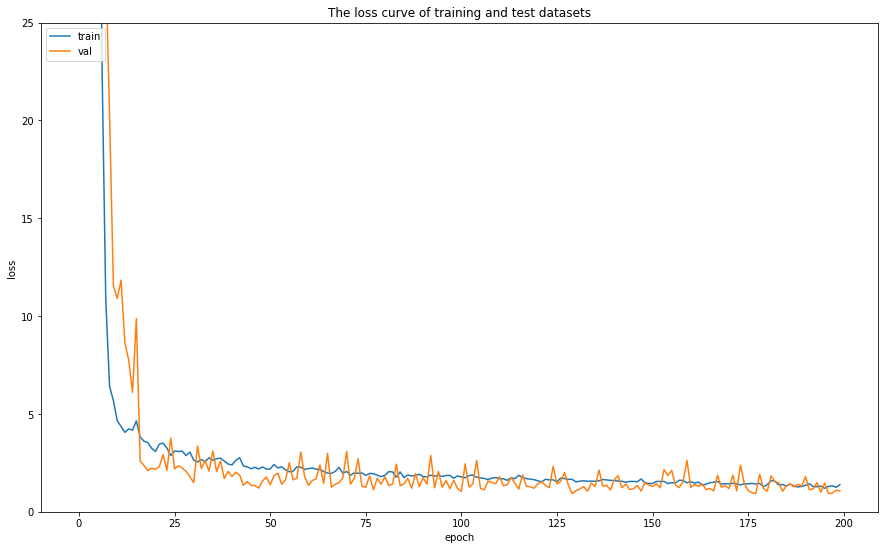

In [146]:
# plot model training history

fig = plt.subplots(figsize=(15, 9))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("The loss curve of training and test datasets")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim([0,25.0])

plt.savefig(os.path.join(results_path,'MSR_loss.png'), dpi = 300)
plt.show()

# 4. Assessing the model performance on test datasets

## 4.1 Save and configure the model with best performance 

In this step, we will configure the model by reloading the weights of best performance through training, and apply it on both the training and validation datasets. The scatter plots will be created to evaluate the model prediction by comparing training and validation datasets, to see if there are over-/under-estimation or over-fitting etc. 

In [147]:
# Load and build the model with the best HP 
#best_model = VGG_model(best_hp_B)
best_model = VGG_model(best_hp_C)
# Build the model with input shape
best_model.build(x_test.shape)
# Load the weights from the best checkpoint
best_model.load_weights(checkpoint_filepath)

## 4.2 Applying the model on validation datasets 

In [148]:
# run the model on the train and test datasets 
y_pred_test = best_model.predict(x_test) 
y_pred_train = best_model.predict(x_train)

In [149]:
# calculate the R2 Score and RMSE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

R2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
mae_train = mean_absolute_error(y_train, y_pred_train)

print("the R2 of training dataset is: %0.4f" %R2_train)
print("the RMSE of training dataset is: %0.4f" %rmse_train)
print("the MAE of training dataset is: %0.4f" %mae_train)

R2_test = r2_score(y_test,y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test,squared=False) 
mae_test = mean_absolute_error(y_test, y_pred_test) 

print("the R2 of validation dataset is: %0.4f" %R2_test)
print("the RMSE of validation dataset is: %0.4f" %rmse_test)
print("the MAE of validation dataset is: %0.4f" %mae_test)

the R2 of training dataset is: 0.6734
the RMSE of training dataset is: 0.9868
the MAE of training dataset is: 0.7686
the R2 of validation dataset is: 0.6849
the RMSE of validation dataset is: 0.9644
the MAE of validation dataset is: 0.7495


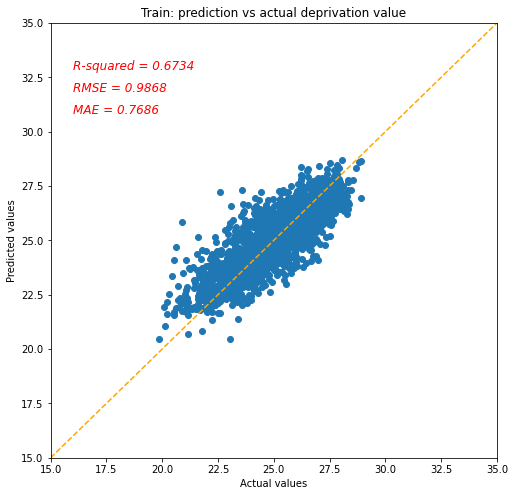

In [150]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_train, y_pred_train)  
ax.plot(np.linspace(15,35,100), np.linspace(15,35,100), c = 'orange', linestyle='--')
ax.set_title("Train: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([15,35.0])
ax.set_ylim([15,35.0])

ax.text(16, 33, "R-squared = %0.4f" % R2_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(16, 32, "RMSE = %0.4f" % rmse_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(16, 31, "MAE = %0.4f" % mae_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig(os.path.join(results_path,'mae_train.png'), dpi = 300)
plt.show()

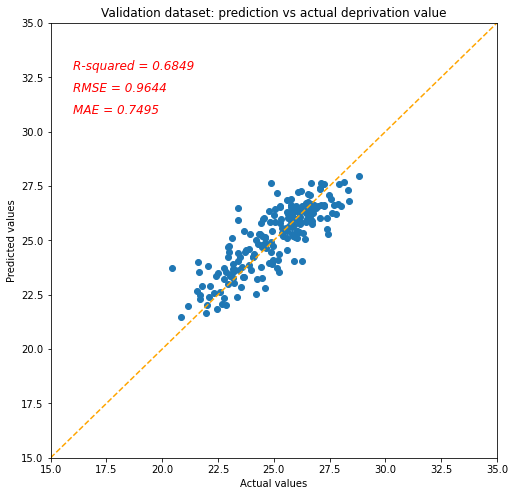

In [151]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_test, y_pred_test)  
ax.plot(np.linspace(15,35,100), np.linspace(15,35,100), c = 'orange', linestyle='--')
ax.set_title("Validation dataset: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([15,35.0])
ax.set_ylim([15,35.0])

ax.text(16, 33, "R-squared = %0.4f" % R2_test, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(16, 32, "RMSE = %0.4f" % rmse_test, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(16, 31, "MAE = %0.4f" % mae_test, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig(os.path.join(results_path,'mae_val.png'), dpi = 300)
plt.show()

## 4.3 Visualize the best and worse predictions

In [272]:
# Get list of image id and corresponding Absolute Error
pred_val_score = [(int(x[0][0]),np.round(np.abs(x[2][0]-x[1][0]),3),x[3],x[2][0]) for x in zip(idx_test.tolist(), y_test.tolist(), y_pred_test.tolist(),x_test.tolist())]
pred_val_score = sorted(pred_val_score, key=lambda x: x[1])
pred_val_score_bestworse = []
[pred_val_score_bestworse.append(x) for x in pred_val_score[:5]] #Best 
[pred_val_score_bestworse.append(x) for x in pred_val_score[-5:]] #Worse

[None, None, None, None, None]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

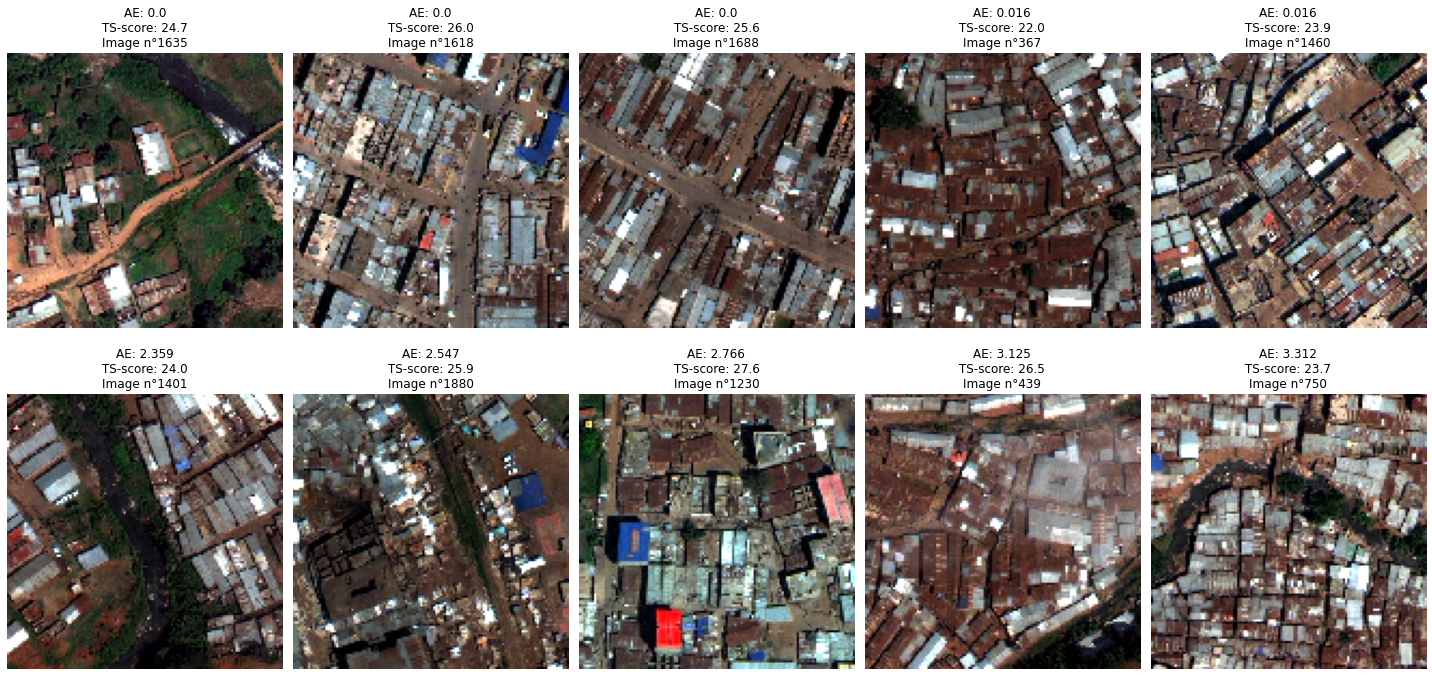

In [273]:
# Visualize the best and worse predictions
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(20, 10))
for i in range(len(pred_val_score_bestworse)):
    if i<=2:
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(Norma_Xpercentile(np.array(pred_val_score_bestworse[i][2])))
        plt.axis("off")
        plt.title("AE: %s\n TS-score: %0.1f \nImage n°%s"%(pred_val_score_bestworse[i][1],pred_val_score_bestworse[i][3],pred_val_score_bestworse[i][0]))
    else:
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(Norma_Xpercentile(np.array(pred_val_score_bestworse[i][2])))
        plt.axis("off")
        plt.title("AE: %s\n TS-score: %0.1f \nImage n°%s"%(pred_val_score_bestworse[i][1],pred_val_score_bestworse[i][3],pred_val_score_bestworse[i][0]))
        
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 
plt.savefig(os.path.join(results_path,'Best_Worse_Prediction.png'), dpi=300, bbox_inches='tight')